In [1]:
from keras.layers import Input, Dense, Flatten, Lambda
from keras.models import Model
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline


## ===========DATASET==============
#https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download

2024-02-22 00:22:59.780913: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Resizing all the images to 224 pixels

In [2]:
image_size = [224,224]

train_path = 'data/chest_xray/train'
test_path = 'data/chest_xray/test'
val_path = 'data/chest_xray/val'

# Applying VGG: 

+ +[3] => for RGB channel
+ Imagenet => pretrained weights
+ include_top = False => removing last layer

In [3]:
vgg = VGG16(input_shape=image_size + [3], weights = 'imagenet', include_top=False)

### layer.trainable = False

Since we use imagenet => pretrained weights, we dont want to retrain the image layers

In [4]:
for layer in vgg.layers:
    layer.trainable = False

In [5]:
from keras.layers import Dense
folders = glob('data/chest_xray/train/*') #read folders inside the train folder
folders


['data/chest_xray/train/PNEUMONIA', 'data/chest_xray/train/NORMAL']

In [6]:
vgg.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [7]:
vgg.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [8]:
x = Flatten()(vgg.output)
pred = Dense(len(folders), activation='softmax')(x)

In [9]:
x

<KerasTensor: shape=(None, 25088) dtype=float32 (created by layer 'flatten')>

In [10]:
pred

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense')>

In [11]:
model = Model(inputs=vgg.input, outputs=pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   zoom_range=0.2, 
                                   shear_range=0.2, 
                                   rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
training_set = train_datagen.flow_from_directory(
    'data/chest_xray/train', 
    target_size=(224, 224), 
    batch_size=32,
    class_mode='categorical'
)

Found 5216 images belonging to 2 classes.


In [15]:
validation_set = val_datagen.flow_from_directory(
    'data/chest_xray/val', 
    target_size=(224, 224), 
    batch_size=32,
    class_mode='categorical'
)

Found 624 images belonging to 2 classes.


In [16]:
test_set = test_datagen.flow_from_directory(
    'data/chest_xray/test', 
    target_size=(224, 224), 
    batch_size=32,
    class_mode='categorical'
)

Found 16 images belonging to 2 classes.


In [17]:
r = model.fit_generator(training_set,
                        validation_data=validation_set,
                        epochs=5, 
                        steps_per_epoch=len(training_set),
                        validation_steps=len(test_set),
                        verbose=True
                        # use_multiprocessing=True,
                        # workers=4
)

/var/folders/z1/8c8tjdhn2z740qzvlw8cs1f80000gn/T/ipykernel_4941/187238395.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(training_set,


Epoch 1/5
163/163 [==============================] - 1846s 11s/step - loss: 0.2189 - accuracy: 0.9191 - val_loss: 0.1907 - val_accuracy: 0.8750
Epoch 2/5
163/163 [==============================] - 1426s 9s/step - loss: 0.1276 - accuracy: 0.9519 - val_loss: 0.4488 - val_accuracy: 0.8750
Epoch 3/5
163/163 [==============================] - 1555s 10s/step - loss: 0.0958 - accuracy: 0.9632 - val_loss: 0.0222 - val_accuracy: 1.0000
Epoch 4/5
163/163 [==============================] - 1420s 9s/step - loss: 0.0819 - accuracy: 0.9695 - val_loss: 0.7854 - val_accuracy: 0.8438
Epoch 5/5
163/163 [==============================] - 1531s 9s/step - loss: 0.0746 - accuracy: 0.9707 - val_loss: 0.4478 - val_accuracy: 0.8438


In [18]:
model.save("VGG16_Pneumonia-prediction.h5")

/Users/joeljoseph26/Documents/Education/Machine_and_Deep_Learning/ML-DL-projects/Image-classification-Projects/Image-Classification-Projects/env/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


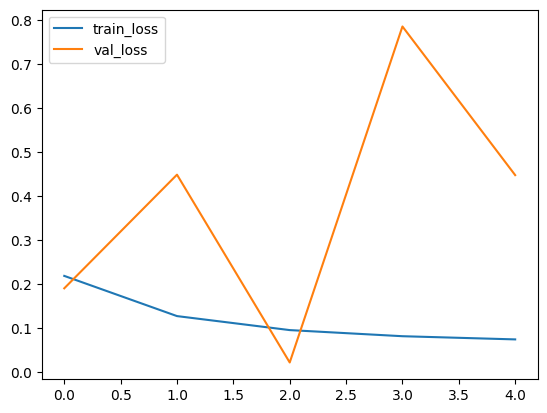

In [19]:
plt.plot(r.history['loss'],label='train_loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

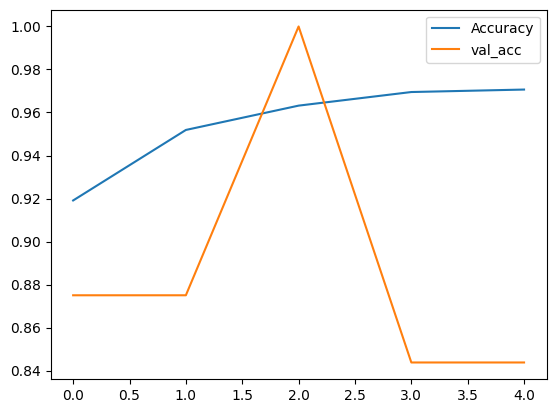

In [22]:
plt.plot(r.history['accuracy'],label='Accuracy')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

## Prediction

In [23]:
from keras.models import load_model

model = load_model('VGG16_Pneumonia-prediction.h5')
img = image.load_img('data/chest_xray/test/PNEUMONIA/person1946_bacteria_4874.jpeg', target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)

1/1 [==============================] - 1s 873ms/step


In [24]:
classes

array([[0., 1.]], dtype=float32)